In [ ]:
# Install PyPortfolioOpt and plotting libraries
!pip install PyPortfolioOpt
!pip install pandas numpy matplotlib yfinance openpyxl

importing and adjusting the dataframe

Data loaded successfully.
Timeframe: 2015-01-30 00:00:00 to 2024-12-31 00:00:00
Assets: ['CSI AGGREGATE BOND INDEX', 'SSE GOVERNMENT BOND INDEX(I)', 'CSI 300', 'CSI 500', 'CSI 1000']


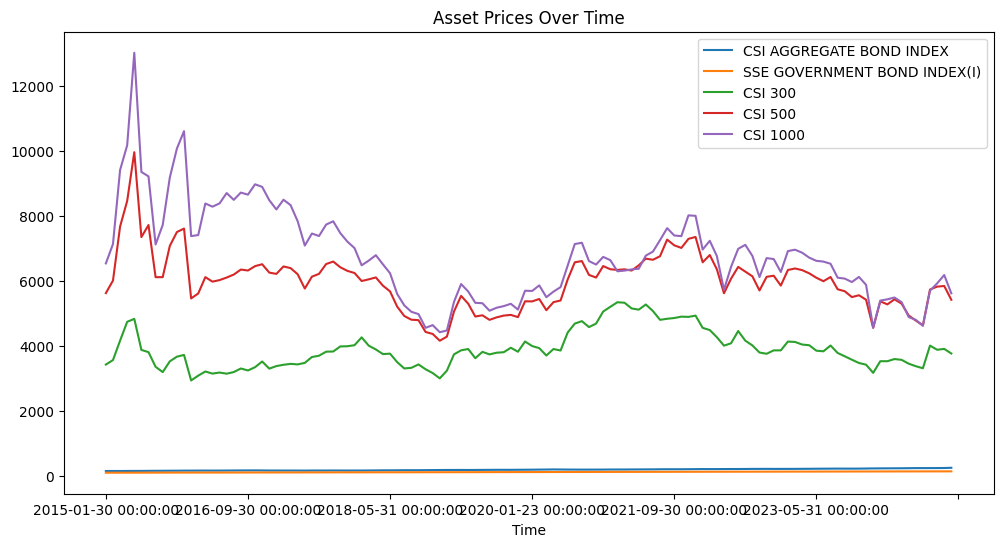

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import expected_returns, risk_models
from pypfopt import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import plotting

# 1. Load the Data
# Ensure the file is uploaded to Colab with this exact name
file_path = '/FIN DATA FIRST PART (1).xlsx'

try:
    # Reading the excel file.
    # Assumption: The first column is Date, and the rest are Asset Prices.
    # Modified: skip the first row and use the second row as header
    df = pd.read_excel(file_path, index_col=0, parse_dates=True, skiprows=1, header=0)

    # basic cleaning: drop missing data if any
    df = df.dropna()

    print("Data loaded successfully.")
    print(f"Timeframe: {df.index[0]} to {df.index[-1]}")
    print(f"Assets: {df.columns.tolist()}")

    # Check if the data looks like prices (values > 1 typically) or returns (values < 1)
    if df.iloc[0, 0] < 2:
        print("Warning: Data looks like returns, not prices. Adjust calculations accordingly.")

    # Plot raw prices to visualize
    df.plot(figsize=(12, 6))
    plt.title("Asset Prices Over Time")
    plt.show()

except FileNotFoundError:
    print(f"Error: File '{file_path}' not found. Please upload it to the Colab files area.")

In [ ]:
print("\nFirst 5 rows of the DataFrame:")
print(df.head())

print("\nDataFrame Column Names:")
print(df.columns)

print("\nDataFrame Data Types:")
print(df.dtypes)


First 5 rows of the DataFrame:
                     CSI AGGREGATE BOND INDEX  SSE GOVERNMENT BOND INDEX(I)  \
Time                                                                          
2015-01-30 00:00:00                  160.0539                       107.715   
2015-02-27 00:00:00                  161.2903                       108.021   
2015-03-31 00:00:00                  160.1959                       108.405   
2015-04-30 00:00:00                  161.9739                       108.702   
2015-05-29 00:00:00                  162.6454                       109.021   

                      CSI 300   CSI 500   CSI 1000  
Time                                                
2015-01-30 00:00:00  3434.390  5632.728   6546.597  
2015-02-27 00:00:00  3572.843  6018.463   7141.888  
2015-03-31 00:00:00  4170.538  7679.010   9419.201  
2015-04-30 00:00:00  4749.886  8469.673  10180.490  
2015-05-29 00:00:00  4840.829  9966.845  13027.210  

DataFrame Column Names:
Index(['CSI AGGREG

download the package needed and check if anything still needed

In [ ]:
# 2. Calculate Expected Returns and Sample Covariance
# mu = Expected Returns
# S = Covariance Matrix

# We use 'mean_historical_return' assuming the data is PRICES.
# If data is already returns, simply use df.mean() * 252 for annualization.
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

print("\nExpected Annual Returns:")
print(mu)

print("\nCovariance Matrix (Head):")
print(S.head())


Expected Annual Returns:
CSI AGGREGATE BOND INDEX        1.778686
SSE GOVERNMENT BOND INDEX(I)    1.014939
CSI 300                         0.221817
CSI 500                        -0.075478
CSI 1000                       -0.274736
dtype: float64

Covariance Matrix (Head):
                              CSI AGGREGATE BOND INDEX  \
CSI AGGREGATE BOND INDEX                      0.009665   
SSE GOVERNMENT BOND INDEX(I)                 -0.000006   
CSI 300                                      -0.019224   
CSI 500                                      -0.013729   
CSI 1000                                     -0.013761   

                              SSE GOVERNMENT BOND INDEX(I)   CSI 300  \
CSI AGGREGATE BOND INDEX                         -0.000006 -0.019224   
SSE GOVERNMENT BOND INDEX(I)                      0.000035  0.000462   
CSI 300                                           0.000462  0.887349   
CSI 500                                           0.000230  0.983439   
CSI 1000          

In [ ]:
# 3. Optimize for Maximum Sharpe Ratio
ef = EfficientFrontier(mu, S)

# Option: Add constraints if required by coursework
# e.g., ef.add_constraint(lambda w: w[0] >= 0.1) # First asset min 10%
# ef.add_sector_constraints({...})

weights_sharpe = ef.max_sharpe()
cleaned_weights_sharpe = ef.clean_weights()

print("\n--- Max Sharpe Portfolio ---")
print(cleaned_weights_sharpe)
ef.portfolio_performance(verbose=True)

# 4. Optimize for Minimum Volatility
ef_min = EfficientFrontier(mu, S)
weights_min = ef_min.min_volatility()
cleaned_weights_min = ef_min.clean_weights()

print("\n--- Minimum Volatility Portfolio ---")
print(cleaned_weights_min)
ef_min.portfolio_performance(verbose=True)


--- Max Sharpe Portfolio ---
OrderedDict({'CSI AGGREGATE BOND INDEX': 0.00683, 'SSE GOVERNMENT BOND INDEX(I)': 0.99317, 'CSI 300': 0.0, 'CSI 500': 0.0, 'CSI 1000': 0.0})
Expected annual return: 102.0%
Annual volatility: 0.6%
Sharpe Ratio: 173.09

--- Minimum Volatility Portfolio ---
OrderedDict({'CSI AGGREGATE BOND INDEX': 0.00415, 'SSE GOVERNMENT BOND INDEX(I)': 0.99585, 'CSI 300': 0.0, 'CSI 500': 0.0, 'CSI 1000': 0.0})
Expected annual return: 101.8%
Annual volatility: 0.6%
Sharpe Ratio: 172.92


(np.float64(1.018112520303235),
 np.float64(0.0058877967441971915),
 np.float64(172.9191010723411))

Expected annual return: 102.0%
Annual volatility: 0.6%
Sharpe Ratio: 173.05


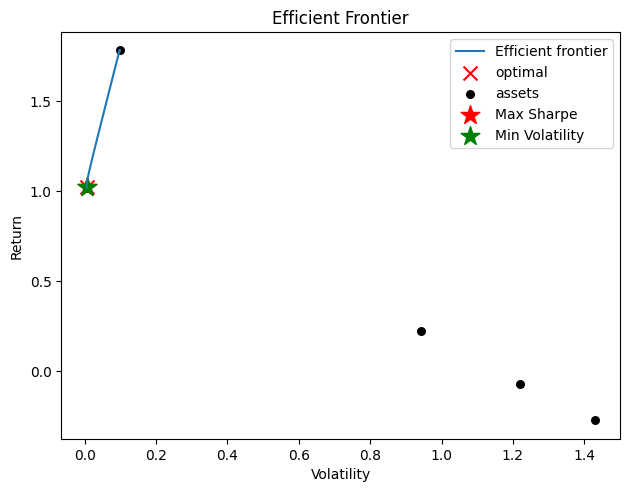

In [ ]:
# 5. Plot the Efficient Frontier
from pypfopt import CLA, plotting

# Use CLA (Critical Line Algorithm) for plotting the frontier line accurately
cla = CLA(mu, S)
cla.max_sharpe()
cla.portfolio_performance(verbose=True)

ax = plotting.plot_efficient_frontier(cla, show_assets=True)

# Add the markers for our specific portfolios found earlier
# We need to re-calculate return/risk for the specific weights to plot dots
ret_sharpe, vol_sharpe, _ = ef.portfolio_performance()
ax.scatter(vol_sharpe, ret_sharpe, marker="*", s=200, c="r", label="Max Sharpe")

# Re-instantiate EF object to get min_vol performance again for plotting
ef_min_plot = EfficientFrontier(mu, S)
ef_min_plot.min_volatility()
ret_min, vol_min, _ = ef_min_plot.portfolio_performance()
ax.scatter(vol_min, ret_min, marker="*", s=200, c="g", label="Min Volatility")

plt.title("Efficient Frontier")
plt.legend()
plt.show()

**Reasoning**:
The previous code block successfully loaded and cleaned the data. To fully confirm that the header has been cleaned and the data types are correct for further analysis, I will display the first few rows, the column names, and the data types of the DataFrame.

